In [128]:
import numpy as np
from scipy.io import wavfile
import os
from scipy import integrate
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics.denoise import SpectralSub
import signal_generator


In [129]:
"""
Prepare input file
"""
snr = 5         # SNR of input signal.
signal_fp = '/Users/axel/KWS/audio/experiment/Alexa_P09_05.wav'
noise_fp = '/Users/axel/KWS/audio/speech_dataset_v0_01/_background_noise_/pink_noise.wav'
generated_fp = '/Users/axel/KWS/audio/experiment/Alexa_P09_05_noised.wav'
filtered_fp = '/Users/axel/KWS/audio/experiment/Alexa_P09_05_filtered.wav'
filtered_iw_fp = '/Users/axel/KWS/audio/experiment/Alexa_P09_05_filtered_iw.wav'

noisy_signal, signal, noise, fs = signal_generator.create_noisy_signal(signal_fp,
                                                          snr=snr,
                                                          noise_fp=noise_fp)
wavfile.write(generated_fp, fs, noisy_signal.astype(np.float32))


In [130]:
"""
Test and algorithm parameters
"""
db_reduc = 40   # Maximum suppression per frequency bin. Large suppresion can result in more musical noise.
nfft = 128      # Frame length will be nfft/2 as we will use an STFT with 50% overlap.
lookback = 48   # How many frames to look back for the noise floor estimate.
beta = 45        # An overestimation factor to "push" the suppression towards db_reduc.
alpha = 1.2     # An exponential factor to tune the suppresion (see documentation of 'SpectralSub').

plot_spec = True

"""
Create STFT and SCNR objects
"""
hop = nfft // 2
window = pra.hann(nfft, flag='asymmetric', length='full')
stft = pra.transform.STFT(nfft, hop=hop, analysis_window=window,
                          streaming=True)

scnr = SpectralSub(nfft, db_reduc, lookback, beta, alpha)
lookback_time = hop/fs * lookback
print("Lookback : %f seconds" % lookback_time)

Lookback : 0.192000 seconds


In [131]:
"""
Process as in real-time
"""
# collect the processed blocks
processed_audio = np.zeros(signal.shape)
n = 0
while noisy_signal.shape[0] - n >= hop:

    # SCNR in frequency domain
    stft.analysis(noisy_signal[n:(n+hop), ])
    gain_filt = scnr.compute_gain_filter(stft.X)

    # back to time domain
    processed_audio[n:n+hop, ] = stft.synthesis(gain_filt*stft.X)

    # update step
    n += hop


In [132]:
wavfile.write(filtered_fp, fs, processed_audio.astype(np.float32))

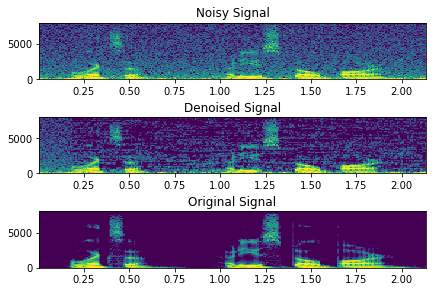

In [133]:
signal_norm = signal / np.abs(signal).max()
if plot_spec:
    min_val = -80
    max_val = -40
    plt.figure()
    plt.subplot(3, 1, 1)
    plt.specgram(noisy_signal[:n-hop], NFFT=256, Fs=fs,
                 vmin=min_val, vmax=max_val)
    plt.title('Noisy Signal')
    plt.subplot(3, 1, 2)
    plt.specgram(processed_audio[hop:n], NFFT=256, Fs=fs,
                 vmin=min_val, vmax=max_val)
    plt.title('Denoised Signal')
    plt.subplot(3, 1, 3)
    plt.specgram(signal_norm[:n-hop], NFFT=256, Fs=fs,
                 vmin=min_val, vmax=max_val)
    plt.title('Original Signal')
    plt.tight_layout(pad=0.5)
    plt.show()